<a href="https://colab.research.google.com/github/maglkp/kaggle/blob/master/5dwdriving4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed May 22 13:03:38 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import pandas as pd
import numpy as np
from PIL import Image
import base64
from io import BytesIO

import matplotlib.pyplot as plt
from keras.models import load_model


from imgaug import augmenters as iaa
from imgaug import parameters as imp

from sklearn.model_selection import train_test_split
import random

%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Lambda
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

from livelossplot import PlotLossesKeras

In [0]:
#!pip install livelossplot
#!pip install imgaug
#!pip install autokeras

In [5]:
X = np.load('X.npy')
y = np.load('y.npy')
X.shape, y.shape

((3216, 60, 80, 3), (3216,))

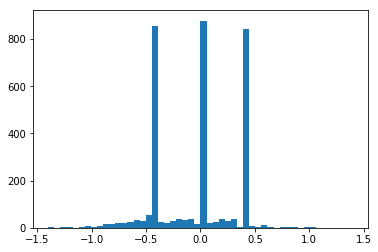

In [6]:
plt.hist(y, 50);

0.0


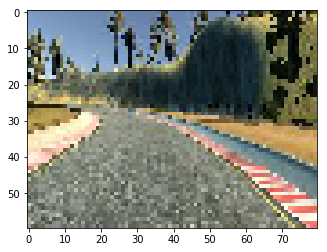

0.275


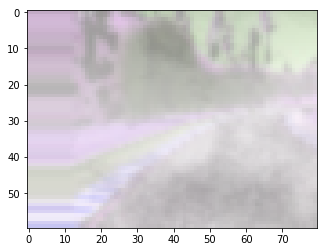

In [7]:
def augment(img, steering_angle):
  if random.random() > .5:
    img = img[:, ::-1, :]
    steering_angle = -steering_angle
  
  blurer = iaa.GaussianBlur(imp.Uniform(.1, 1));
  img = blurer.augment_image(img);
  
  sh = iaa.ChannelShuffle(p=.5)
  img = sh.augment_image(img)
  
  fog = iaa.Fog()
  img = fog.augment_image(img)
  
  tx = random.randint(-20, 20)
  translator = iaa.Affine(translate_px= {"x": tx}, mode='edge')
  img = translator.augment_image(img)
  steering_angle += tx*.025
  
  return img, steering_angle


plt.imshow(X[0])

print(y[0]);
plt.show();

img, angle = augment(X[0], y[0])
plt.imshow(img);
print(angle);
plt.show();

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=43)
print(X_train.shape, y_train.shape)

(2572, 60, 80, 3) (2572,)


In [9]:
Xgen = []
ygen = []
for i in range(X_train.shape[0]):
  img, angle = augment(X[i], y[i])
  Xgen.append(img)
  ygen.append(angle)
  
Xgen = np.array(Xgen)
ygen = np.array(ygen)
print(Xgen.shape, ygen.shape)

(2572, 60, 80, 3) (2572,)


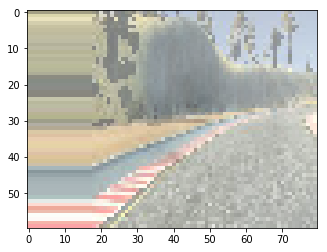

In [0]:
plt.imshow(Xgen[0])

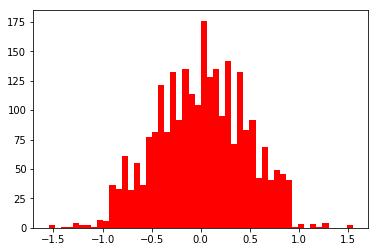

In [0]:
#plt.hist(y_train, 50, facecolor='green');
plt.hist(ygen, 50, facecolor='red');

In [0]:
def my_model(input_shape):
	return Sequential([
		Lambda(lambda x: (x-128.)/255., input_shape=input_shape, name='normalize'),
		Conv2D(64, (3,3), activation='relu'),
    #    MaxPooling2D(pool_size=(2,2)),
		Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
		Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
		Conv2D(6, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(rate=.5),
		Flatten(),
		Dense(512, activation='relu'),
    Dropout(rate=.3),
		Dense(512, activation='relu'),
    Dropout(rate=.3),
		Dense(16, activation='relu'),
		Dense(1)
	])

model = my_model(X[0].shape)
model.summary()
model.compile('adam', 'mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 58, 78, 64)        1792      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 56, 76, 32)        18464     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 26, 36, 16)        4624      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 18, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 16, 6)         870       
__________

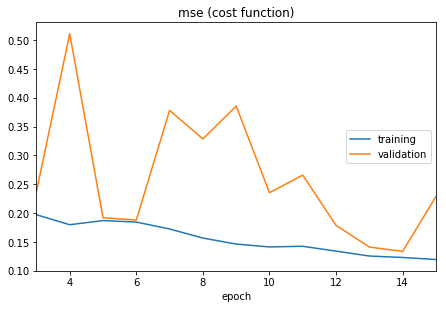

mse (cost function):
training   (min:    0.119, max:    0.207, cur:    0.119)
validation (min:    0.133, max:    0.511, cur:    0.228)


In [0]:
batch_size=512
epochs=15

model.fit(Xgen, ygen,
		  batch_size,
		  epochs,
		  validation_data=(X_val, y_val),
		  callbacks=[PlotLossesKeras()])

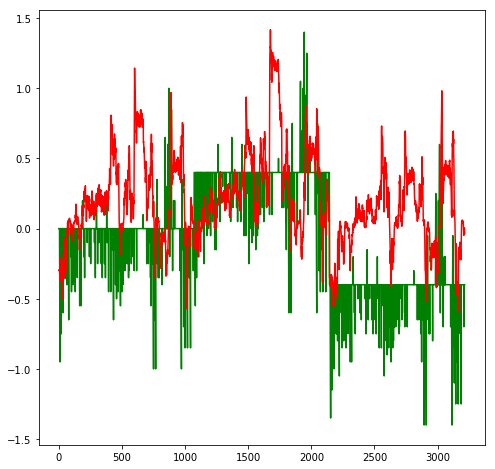

In [0]:
ypred=model.predict(X)
plt.figure(figsize=(8,8))
plt.plot(y, 'g', ypred, 'r')
plt.show();

In [0]:
model.save('mymodel.h5')

In [10]:
import autokeras as ak

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [11]:
model_ak = ak.ImageRegressor(verbose=True)
model_ak.fit(Xgen, ygen, time_limit=30*60)

Saving Directory: /tmp/autokeras_ZRSFP9
Preprocessing the images.
Preprocessing finished.

Initializing search.
Initialization finished.


+----------------------------------------------+
|               Training model 0               |
+----------------------------------------------+
                                                                                                    
No loss decrease after 5 epochs.


Saving model.
+--------------------------------------------------------------------------+
|        Model ID        |          Loss          |      Metric Value      |
+--------------------------------------------------------------------------+
|           0            |  0.41584682166576387   |  0.20785898237384054   |
+--------------------------------------------------------------------------+


+----------------------------------------------+
|               Training model 1               |
+----------------------------------------------+
                              

In [13]:
score = model_ak.evaluate(X_val, y_val)
print(score)

0.14949921980881856


In [0]:
ypred = model_ak.predict(X)

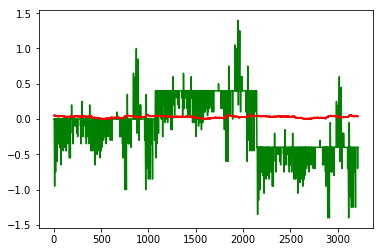

In [15]:
plt.plot(y, 'g', ypred, 'r')
plt.show();

In [0]:
model_ak.export_autokeras_model('model.pkl')
#model_ak.export_keras_model('autokeras.h5')

In [0]:
from autokeras.utils import pickle_from_file
model = pickle_from_file('model.pkl')

yp = model.predict(X_val)